# Wildfire Forecasting (Weekly, Spatio-Temporal)

**Goal.** Extend the baseline NASA FIRMS analysis to **forecast weekly fire activity** on a simple spatial grid.

**What’s different from the baseline?**  
Here we:
1) Aggregate point detections → **weekly counts per lat/lon bin (0.25°)**  
2) Build **time-series features** (lags + seasonality)  
3) Compare **true TS baselines** (Naïve, MA(4)) with **ARIMA/Prophet** and **XGBoost**  
4) Evaluate with MAE/RMSE/MAPE + plots

**Output of this notebook**
- `data/processed/firms_weekly.parquet` (counts per bin/week)  
- a small feature table for modeling  
- backtest scores + a saved model for later visualizations


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

plt.style.use("seaborn-v0_8")

RAW_PATH = "../data/raw/fire_archive_M-C61_634551.csv"


In [3]:
#only needed columns
usecols = ["latitude", "longitude", "acq_date", "confidence"]

df = pd.read_csv(RAW_PATH, usecols=usecols, parse_dates=["acq_date"])

#filter out low-confidence detections
df = df[df["confidence"] >= 50]

df.head()


,latitude,longitude,acq_date,confidence
0,48.4610,38.7808,2024-01-01,82
1,-15.2828,132.3189,2024-01-01,94
2,-15.0487,132.6429,2024-01-01,69
3,-15.2938,132.3170,2024-01-01,51
4,-15.0463,132.6290,2024-01-01,77


In [4]:
# 0.25° grid bins
STEP = 0.25
def bin_edges(v, step=STEP):
    return np.floor(v / step) * step

gdf = df.copy()
gdf["lat_bin"] = bin_edges(gdf["latitude"])
gdf["lon_bin"] = bin_edges(gdf["longitude"])
gdf["week"] = pd.to_datetime(gdf["acq_date"]).dt.to_period("W").dt.start_time

weekly = (gdf.groupby(["lat_bin","lon_bin","week"])
            .size().reset_index(name="fire_count"))
weekly["fire_occurrence"] = (weekly["fire_count"] > 0).astype(int)

# quick sanity check
display(weekly.head())
print("Cells x weeks:", weekly[["lat_bin","lon_bin","week"]].drop_duplicates().shape[0],
      "| rows:", len(weekly),
      "| date range:", weekly["week"].min().date(), "→", weekly["week"].max().date())

# save
out_path = Path("../data/processed/firms_weekly.parquet")
out_path.parent.mkdir(parents=True, exist_ok=True)
weekly.to_parquet(out_path, index=False)
print("Saved to", out_path)

,lat_bin,lon_bin,week,fire_count,fire_occurrence
0,-75.00,-45.75,2024-09-30,2,1
1,-53.75,-68.00,2024-01-15,1,1
2,-52.75,-68.75,2024-06-17,1,1
3,-52.75,-68.75,2024-07-01,2,1
4,-52.00,-158.00,2024-03-11,1,1


Cells x weeks: 620655 | rows: 620655 | date range: 2024-01-01 → 2024-12-30
Saved to ..\data\processed\firms_weekly.parquet


In [5]:
weekly = pd.read_parquet("../data/processed/firms_weekly.parquet").sort_values(["lat_bin","lon_bin","week"]).copy()

# Lags (valeurs passées) par cellule
weekly["lag1"] = weekly.groupby(["lat_bin","lon_bin"])["fire_count"].shift(1).fillna(0)
weekly["lag4_sum"] = (weekly.groupby(["lat_bin","lon_bin"])["fire_count"]
                        .rolling(window=4, min_periods=1).sum()
                        .reset_index(level=["lat_bin","lon_bin"], drop=True)
                        .shift(1).fillna(0))

wk = weekly["week"].dt.isocalendar().week.astype(int)
weekly["w_sin"] = np.sin(2*np.pi*wk/52)
weekly["w_cos"] = np.cos(2*np.pi*wk/52)

display(weekly.head())

weeks = sorted(weekly["week"].unique())
cutoff = int(0.8 * len(weeks))
train_weeks, test_weeks = weeks[:cutoff], weeks[cutoff:]

train = weekly[weekly["week"].isin(train_weeks)]
test  = weekly[weekly["week"].isin(test_weeks)]

FEATURES = ["lag1","lag4_sum","w_sin","w_cos"]
TARGET = "fire_count"

X_train, y_train = train[FEATURES], train[TARGET]
X_test,  y_test  = test[FEATURES],  test[TARGET]

print(f"Train weeks: {train_weeks[0].date()} → {train_weeks[-1].date()} | rows={len(train)}")
print(f"Test  weeks: {test_weeks[0].date()}  → {test_weeks[-1].date()}  | rows={len(test)}")


,lat_bin,lon_bin,week,fire_count,fire_occurrence,lag1,lag4_sum,w_sin,w_cos
0,-75.00,-45.75,2024-09-30,2,1,0.0,0.0,-0.992709,0.120537
1,-53.75,-68.00,2024-01-15,1,1,0.0,2.0,0.354605,0.935016
2,-52.75,-68.75,2024-06-17,1,1,0.0,1.0,0.120537,-0.992709
3,-52.75,-68.75,2024-07-01,2,1,1.0,1.0,-0.120537,-0.992709
4,-52.00,-158.00,2024-03-11,1,1,0.0,3.0,0.970942,0.239316


Train weeks: 2024-01-01 → 2024-10-14 | rows=515740
Test  weeks: 2024-10-21  → 2024-12-30  | rows=104915


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline 1: Naïve (toujours prédire la semaine précédente)
y_pred_naive = X_test["lag1"]

# Baseline 2: Moyenne mobile (4 semaines)
y_pred_ma4 = X_test["lag4_sum"] / 4.0

# Évaluer
def eval_baseline(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{name} → MAE: {mae:.3f} | RMSE: {rmse:.3f}")

eval_baseline(y_test, y_pred_naive, "Naïve (lag1)")
eval_baseline(y_test, y_pred_ma4,   "MA(4)")

Naïve (lag1) → MAE: 4.276 | RMSE: 10.626
MA(4) → MAE: 4.395 | RMSE: 10.029


C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


week
2024-01-01    61845
2024-01-08    72443
2024-01-15    76336
2024-01-22    67457
2024-01-29    47159
Freq: W-MON, Name: fire_count, dtype: int64 
 week
2024-12-02    47983
2024-12-09    57880
2024-12-16    59637
2024-12-23    59989
2024-12-30    24725
Freq: W-MON, Name: fire_count, dtype: int64 
 nonzero weeks: 53
ARIMA(2,1,2) → MAE=21290.118 | RMSE=23411.079


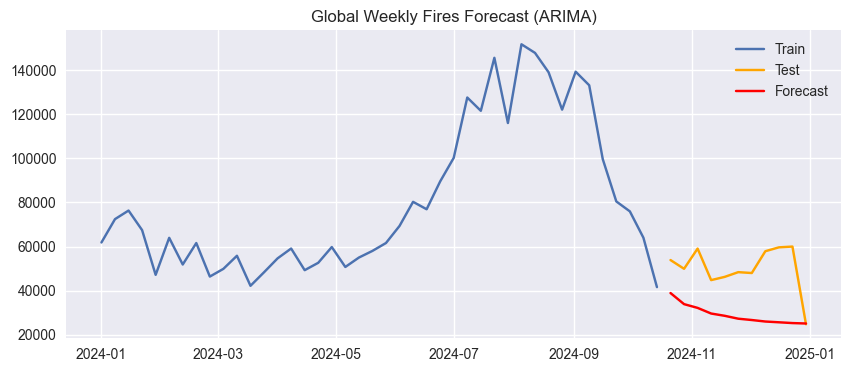

In [7]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Build the global weekly series with the SAME anchor as we created earlier (week start = Monday)
global_weekly = (
    weekly
    .set_index("week")["fire_count"]
    .resample("W-MON")   # weekly, anchored on Monday
    .sum()
)

# Quick sanity check
print(global_weekly.head(), "\n", global_weekly.tail(), "\n",
      "nonzero weeks:", (global_weekly>0).sum())

# Split 80/20
cutoff = int(0.8 * len(global_weekly))
train_series = global_weekly.iloc[:cutoff]
test_series  = global_weekly.iloc[cutoff:]

# ARIMA 
arima_model = sm.tsa.ARIMA(train_series, order=(2,1,2))
arima_res = arima_model.fit()

# Forecast next len(test) weeks
forecast = arima_res.forecast(steps=len(test_series))

mae = mean_absolute_error(test_series, forecast)
rmse = np.sqrt(mean_squared_error(test_series, forecast))
print(f"ARIMA(2,1,2) → MAE={mae:.3f} | RMSE={rmse:.3f}")

plt.figure(figsize=(10,4))
plt.plot(train_series.index, train_series, label="Train")
plt.plot(test_series.index, test_series, label="Test", color="orange")
plt.plot(test_series.index, forecast, label="Forecast", color="red")
plt.legend()
plt.title("Global Weekly Fires Forecast (ARIMA)")
plt.show()

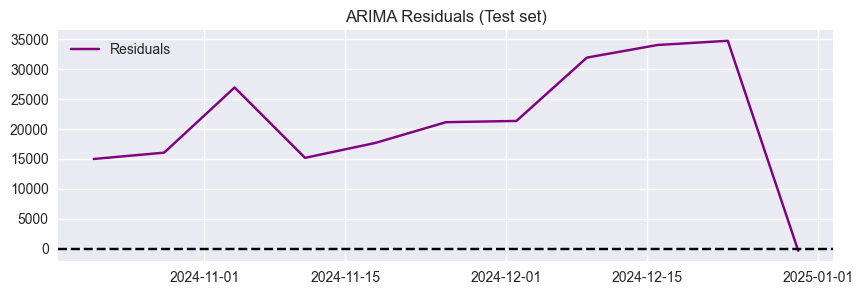

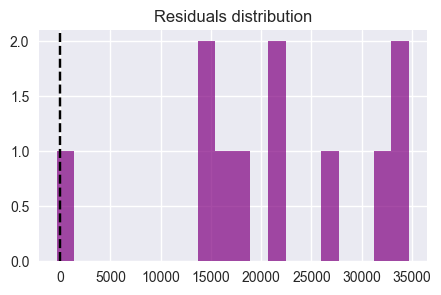

Residual mean: 21225.96241531081
Residual std: 10358.128956464145


In [8]:
# Residuals = actual - forecast
residuals = test_series - forecast

# Plot residuals
plt.figure(figsize=(10,3))
plt.plot(residuals, label="Residuals", color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.title("ARIMA Residuals (Test set)")
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(5,3))
plt.hist(residuals, bins=20, color="purple", alpha=0.7)
plt.axvline(0, color="black", linestyle="--")
plt.title("Residuals distribution")
plt.show()

# Basic stats
print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())


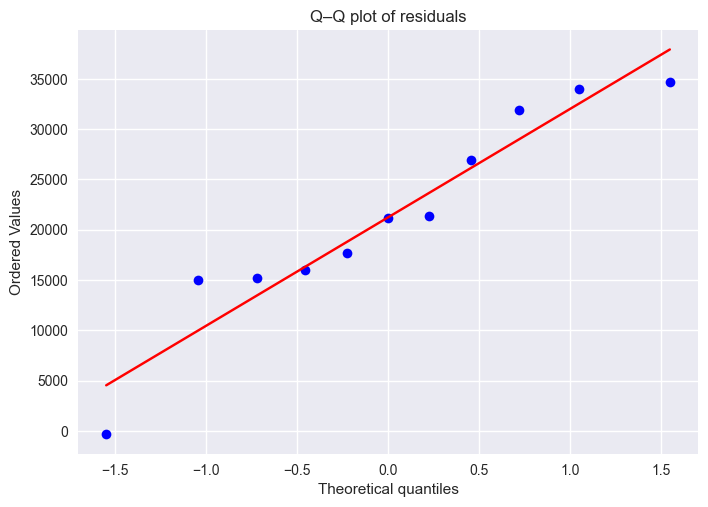

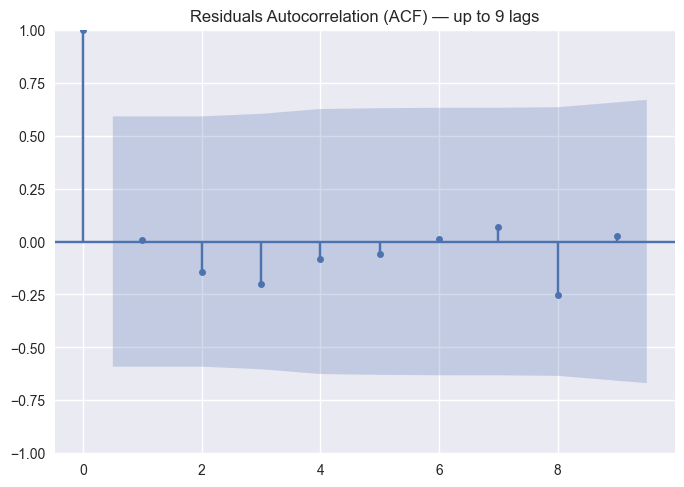

Ljung–Box p-value at lag 9: 0.8700


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

resid = residuals.dropna().astype(float)
n = len(resid)
max_lag = max(1, min(10, n - 2))  

# Q–Q plot 
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Q–Q plot of residuals")
plt.show()

sm.graphics.tsa.plot_acf(resid, lags=max_lag)
plt.title(f"Residuals Autocorrelation (ACF) — up to {max_lag} lags")
plt.show()

lb = acorr_ljungbox(resid, lags=[max_lag], return_df=True)
print(f"Ljung–Box p-value at lag {max_lag}: {lb['lb_pvalue'].iloc[0]:.4f}")


Bias-corrected ARIMA → MAE=7771.85 | RMSE=9876.09


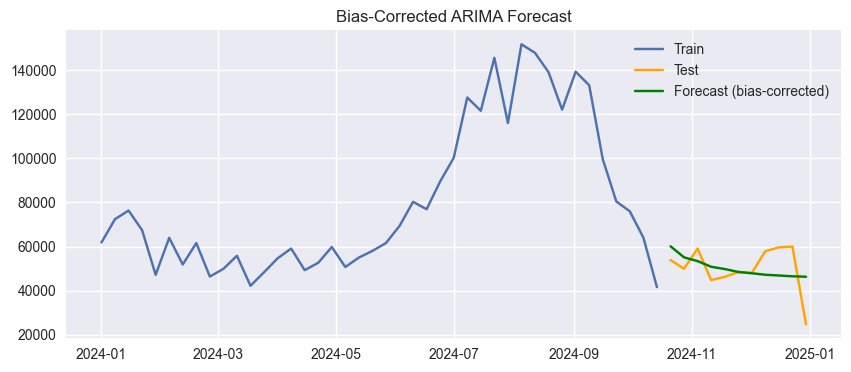

In [10]:
# Bias correction
forecast_corrected = forecast + residuals.mean()

# Re-evaluate
mae_corr = mean_absolute_error(test_series, forecast_corrected)
rmse_corr = np.sqrt(mean_squared_error(test_series, forecast_corrected))

print(f"Bias-corrected ARIMA → MAE={mae_corr:.2f} | RMSE={rmse_corr:.2f}")

plt.figure(figsize=(10,4))
plt.plot(train_series.index, train_series, label="Train")
plt.plot(test_series.index, test_series, label="Test", color="orange")
plt.plot(test_series.index, forecast_corrected, label="Forecast (bias-corrected)", color="green")
plt.legend()
plt.title("Bias-Corrected ARIMA Forecast")
plt.show()


09:46:33 - cmdstanpy - INFO - Chain [1] start processing
09:46:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet → MAE=60773.51 | RMSE=69465.46


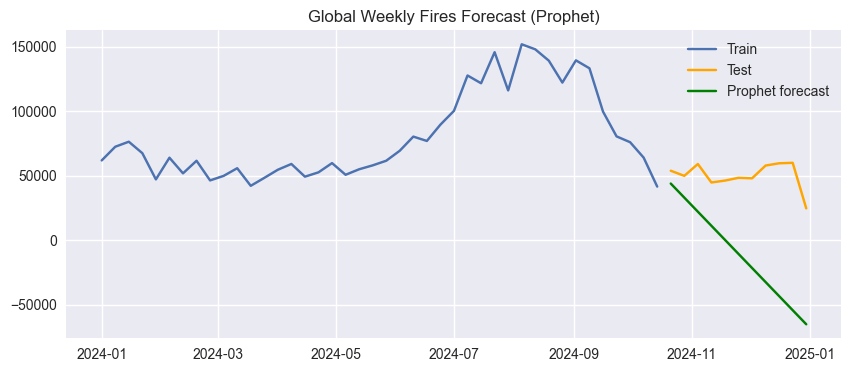

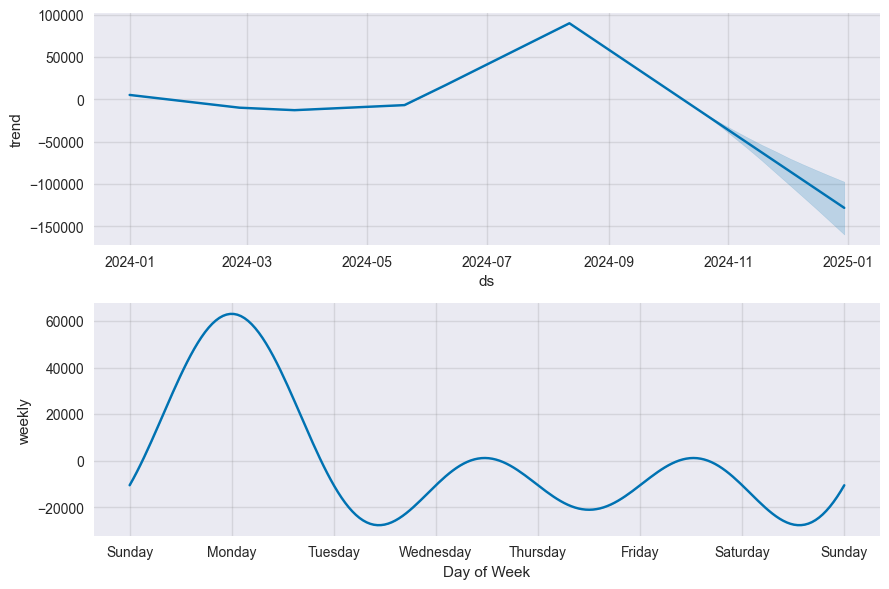

In [12]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare Prophet dataframe from global_weekly
df_prophet = global_weekly.reset_index().rename(columns={"week":"ds","fire_count":"y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])

# Split train/test exactly like ARIMA (80/20)
cutoff = int(0.8 * len(df_prophet))
train_p = df_prophet.iloc[:cutoff].copy()
test_p  = df_prophet.iloc[cutoff:].copy()

# Fit Prophet (weekly seasonality on and yearly off since we have ~1y)
m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,   # a bit more flexible trend
)
m.fit(train_p)

# Forecast horizon = len(test)
future = m.make_future_dataframe(periods=len(test_p), freq="W-MON")
fcst = m.predict(future)

# Keep only the forecasted part aligned with test
pred = fcst.set_index("ds").loc[test_p["ds"], "yhat"]

# Evaluate
mae_prophet = mean_absolute_error(test_p["y"], pred)
rmse_prophet = np.sqrt(mean_squared_error(test_p["y"], pred))
print(f"Prophet → MAE={mae_prophet:.2f} | RMSE={rmse_prophet:.2f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(train_p["ds"], train_p["y"], label="Train")
plt.plot(test_p["ds"],  test_p["y"],  label="Test", color="orange")
plt.plot(test_p["ds"],  pred,         label="Prophet forecast", color="green")
plt.legend(); plt.title("Global Weekly Fires Forecast (Prophet)"); plt.show()

# components (trend/weekly)
m.plot_components(fcst);


In [13]:
from prophet.diagnostics import cross_validation, performance_metrics


df_cv = cross_validation(
    m,
    initial="150 days",   # ~5 months of training
    period="30 days",     # roll forward monthly
    horizon="60 days"     # forecast 2 months ahead
)

df_perf = performance_metrics(df_cv)
df_perf.head()


  0%|          | 0/3 [00:00<?, ?it/s]

09:46:36 - cmdstanpy - INFO - Chain [1] start processing
09:46:37 - cmdstanpy - INFO - Chain [1] done processing
09:46:37 - cmdstanpy - INFO - Chain [1] start processing
09:46:38 - cmdstanpy - INFO - Chain [1] done processing
09:46:38 - cmdstanpy - INFO - Chain [1] start processing
09:46:39 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2.390152e+08,15460.117101,11551.349961,0.086751,0.086751,0.081113,0.5
1,6 days,3.322529e+08,18227.806589,17770.864974,0.125541,0.125541,0.122159,0.0
2,8 days,1.486585e+08,12192.558750,12082.802609,0.105430,0.105430,0.111372,0.0
3,11 days,1.161233e+09,34076.873938,28747.870295,0.250958,0.250958,0.223466,0.0
4,13 days,1.421237e+09,37699.293685,36064.743214,0.300678,0.300678,0.259031,0.0


C:\Users\Manal\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
C:\Users\Manal\anaconda3\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
C:\Users\Manal\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
C:\Users\Manal\anaconda3\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and w

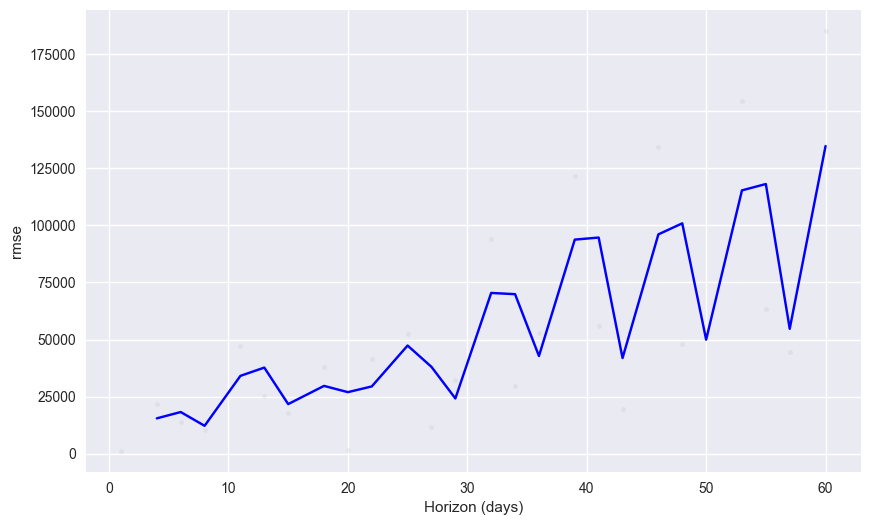

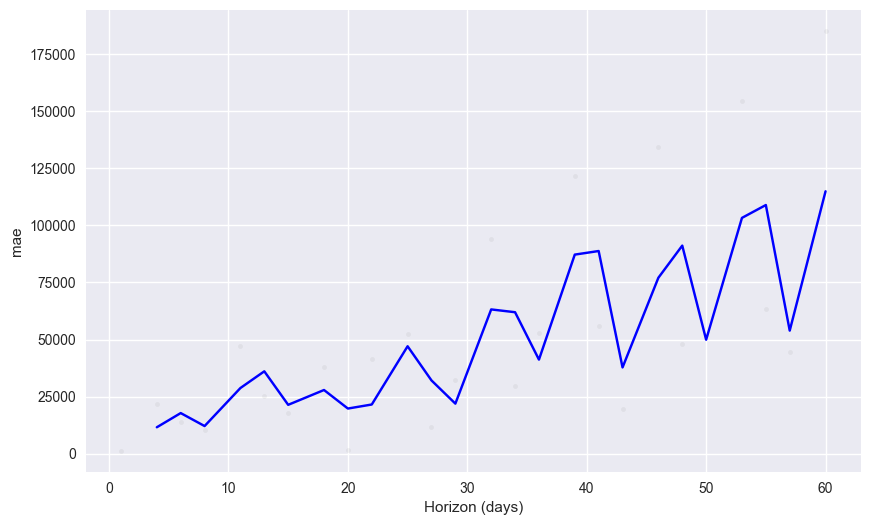

In [14]:
from prophet.plot import plot_cross_validation_metric

# RMSE across different forecast horizons
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# MAE
fig = plot_cross_validation_metric(df_cv, metric='mae')


XGBoost ➜ MAE=5.14 | RMSE=9.82 | SMAPE=85.24%


C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Figure size 600x400 with 0 Axes>

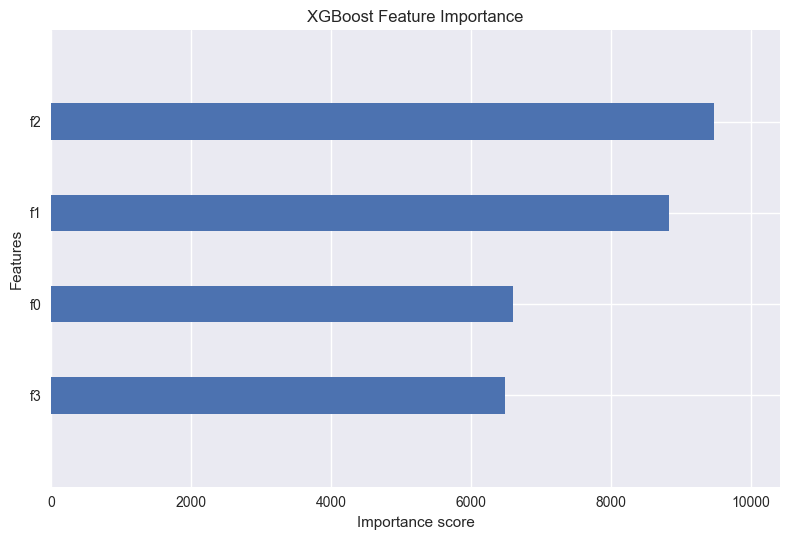

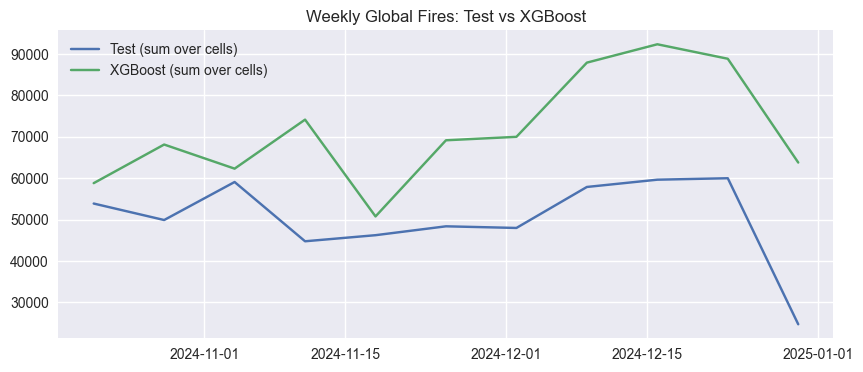

Saved global aggregated XGB forecast to data\processed\forecast_xgb_global.parquet


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor, plot_importance

# ---- config ----
FEATURES = ["lag1", "lag4_sum", "w_sin", "w_cos"]
TARGET = "fire_count"

missing = [c for c in FEATURES + [TARGET, "week"] if c not in weekly.columns]
assert not missing, f"Missing columns in 'weekly': {missing}"

# Keep only rows with all features available
data = weekly.dropna(subset=FEATURES + [TARGET]).copy()

weeks = sorted(data["week"].unique())
cutoff = int(0.8 * len(weeks))
train_weeks, test_weeks = weeks[:cutoff], weeks[cutoff:]

train = data[data["week"].isin(train_weeks)].copy()
test  = data[data["week"].isin(test_weeks)].copy()

val_cut = int(0.9 * len(train_weeks))
tr_weeks, val_weeks = train_weeks[:val_cut], train_weeks[val_cut:]

tr  = train[train["week"].isin(tr_weeks)]
val = train[train["week"].isin(val_weeks)]

X_tr,  y_tr  = tr[FEATURES].values,  tr[TARGET].values
X_val, y_val = val[FEATURES].values, val[TARGET].values
X_test, y_test = test[FEATURES].values, test[TARGET].values

xgb = XGBRegressor(
    n_estimators=600,         
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse",        
)

try:
    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
except TypeError:
    # even older versions might not accept eval_set verbosity flags
    xgb.fit(X_tr, y_tr)

# ---- predict (clip negatives to 0 for counts) ----
y_pred = xgb.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

# ---- metrics ----
def smape(y_true, y_pred, eps=1e-8):
    denom = (np.abs(y_true) + np.abs(y_pred) + eps) / 2.0
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
smp  = smape(y_test, y_pred)

best_iter = getattr(xgb, "best_iteration", None)
best_info = f" | Best iteration: {best_iter}" if best_iter is not None else ""

print(f"XGBoost ➜ MAE={mae:,.2f} | RMSE={rmse:,.2f} | SMAPE={smp:,.2f}%{best_info}")

# ---- feature importance ----
plt.figure(figsize=(6,4))
try:
    plot_importance(xgb, height=0.4, show_values=False)
except Exception:
    # fallback if plot_importance shape differs in your version
    importances = getattr(xgb, "feature_importances_", None)
    if importances is not None:
        order = np.argsort(importances)[::-1]
        plt.bar([FEATURES[i] for i in order], importances[order])
    else:
        plt.text(0.5, 0.5, "Feature importance unavailable", ha="center")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


test_plot = test[["week"]].copy()
test_plot["y_true"] = y_test
test_plot["y_pred"] = y_pred
agg = test_plot.groupby("week")[["y_true","y_pred"]].sum().sort_index()

plt.figure(figsize=(10,4))
plt.plot(agg.index, agg["y_true"], label="Test (sum over cells)")
plt.plot(agg.index, agg["y_pred"], label="XGBoost (sum over cells)")
plt.legend()
plt.title("Weekly Global Fires: Test vs XGBoost")
plt.show()

metrics_row = pd.DataFrame([{"model":"xgboost", "MAE":mae, "RMSE":rmse, "SMAPE":smp}])
try:
    METRICS_PATH = Path("data/processed/metrics.csv")
    METRICS_PATH.parent.mkdir(parents=True, exist_ok=True)
    if METRICS_PATH.exists():
        pd.concat([pd.read_csv(METRICS_PATH), metrics_row], ignore_index=True).to_csv(METRICS_PATH, index=False)
    else:
        metrics_row.to_csv(METRICS_PATH, index=False)
except Exception as e:
    print("Skipping metrics save:", e)

try:
    OUT_FORECAST = Path("data/processed/forecast_xgb_global.parquet")
    OUT_FORECAST.parent.mkdir(parents=True, exist_ok=True)
    agg.reset_index().to_parquet(OUT_FORECAST, index=False)
    print("Saved global aggregated XGB forecast to", OUT_FORECAST)
except Exception as e:
    print("Skipping forecast save:", e)


C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

Best params: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Validation RMSE=12.32


C:\Users\Manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Tuned XGB ➜ MAE=5.02 | RMSE=9.39 | SMAPE=84.83%


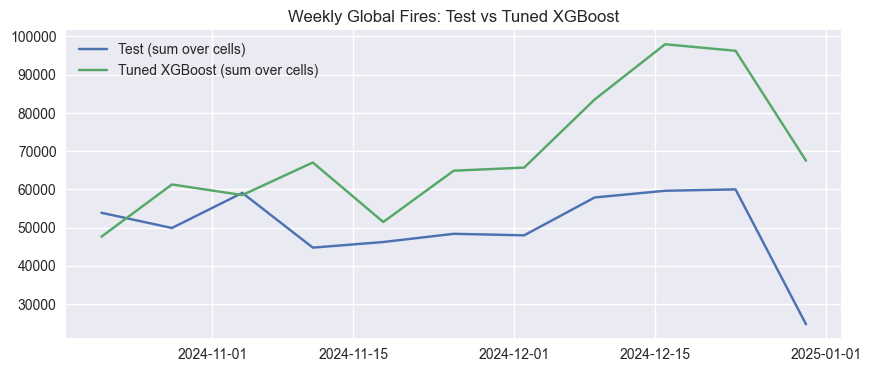

In [22]:
from sklearn.model_selection import ParameterSampler

param_grid = {
    "max_depth": [3, 4, 6],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "n_estimators": [300, 600, 900],
    "min_child_weight": [1, 5, 10],
}

param_list = list(ParameterSampler(param_grid, n_iter=15, random_state=42))

best_score = float("inf")
best_params = None

for params in param_list:
    model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        eval_metric="rmse",
        **params
    )
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    preds = np.clip(model.predict(X_val), 0, None)
    rmse = mean_squared_error(y_val, preds, squared=False)
    if rmse < best_score:
        best_score = rmse
        best_params = params

print("Best params:", best_params)
print(f"Validation RMSE={best_score:,.2f}")

X_full, y_full = train[FEATURES].values, train[TARGET].values
xgb_best = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse",
    **best_params
)
xgb_best.fit(X_full, y_full, verbose=False)

y_pred_best = np.clip(xgb_best.predict(X_test), 0, None)

mae  = mean_absolute_error(y_test, y_pred_best)
rmse = mean_squared_error(y_test, y_pred_best, squared=False)
smp  = smape(y_test, y_pred_best)

print(f"Tuned XGB ➜ MAE={mae:,.2f} | RMSE={rmse:,.2f} | SMAPE={smp:,.2f}%")

test_plot = test[["week"]].copy()
test_plot["y_true"] = y_test
test_plot["y_pred"] = y_pred_best
agg = test_plot.groupby("week")[["y_true","y_pred"]].sum().sort_index()

plt.figure(figsize=(10,4))
plt.plot(agg.index, agg["y_true"], label="Test (sum over cells)")
plt.plot(agg.index, agg["y_pred"], label="Tuned XGBoost (sum over cells)")
plt.legend()
plt.title("Weekly Global Fires: Test vs Tuned XGBoost")
plt.show()


XGB (bias-corrected) ➜ MAE=5.01 | RMSE=9.39 | SMAPE=84.62%  | bias=-0.02


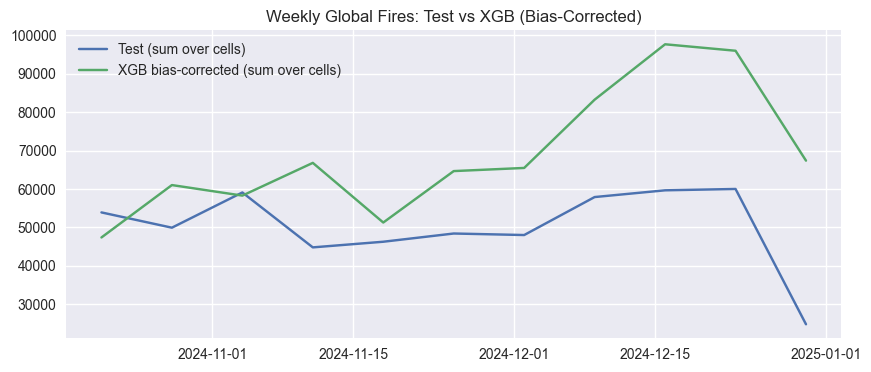

Saved global aggregated bias-corrected forecast to data\processed\forecast_xgb_bias_corrected_global.parquet


In [26]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
model = xgb_best if "xgb_best" in locals() else xgb

val_pred = np.clip(model.predict(X_val), 0, None)
bias = (y_val - val_pred).mean()

y_pred_bc = np.clip(model.predict(X_test) + bias, 0, None)

def smape(y_true, y_pred, eps=1e-8):
    denom = (np.abs(y_true) + np.abs(y_pred) + eps) / 2.0
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

mae  = mean_absolute_error(y_test, y_pred_bc)
rmse = root_mean_squared_error(y_test, y_pred_bc)
smp  = smape(y_test, y_pred_bc)
print(f"XGB (bias-corrected) ➜ MAE={mae:,.2f} | RMSE={rmse:,.2f} | SMAPE={smp:,.2f}%  | bias={bias:,.2f}")

test_plot = test[["week"]].copy()
test_plot["y_true"] = y_test
test_plot["y_pred_bc"] = y_pred_bc
agg_bc = test_plot.groupby("week")[["y_true","y_pred_bc"]].sum().sort_index()

plt.figure(figsize=(10,4))
plt.plot(agg_bc.index, agg_bc["y_true"], label="Test (sum over cells)")
plt.plot(agg_bc.index, agg_bc["y_pred_bc"], label="XGB bias-corrected (sum over cells)")
plt.legend(); plt.title("Weekly Global Fires: Test vs XGB (Bias-Corrected)"); plt.show()

try:
    METRICS_PATH = Path("data/processed/metrics.csv"); METRICS_PATH.parent.mkdir(parents=True, exist_ok=True)
    row = pd.DataFrame([{"model":"xgb_bias_corrected","MAE":mae,"RMSE":rmse,"SMAPE":smp,"bias":bias}])
    if METRICS_PATH.exists():
        pd.concat([pd.read_csv(METRICS_PATH), row], ignore_index=True).to_csv(METRICS_PATH, index=False)
    else:
        row.to_csv(METRICS_PATH, index=False)
except Exception as e:
    print("Skipping metrics save:", e)

try:
    OUT = Path("data/processed/forecast_xgb_bias_corrected_global.parquet"); OUT.parent.mkdir(parents=True, exist_ok=True)
    agg_bc.reset_index().to_parquet(OUT, index=False)
    print("Saved global aggregated bias-corrected forecast to", OUT)
except Exception as e:
    print("Skipping forecast save:", e)


XGB (log target) ➜ MAE=4.46 | RMSE=10.02 | SMAPE=73.42%


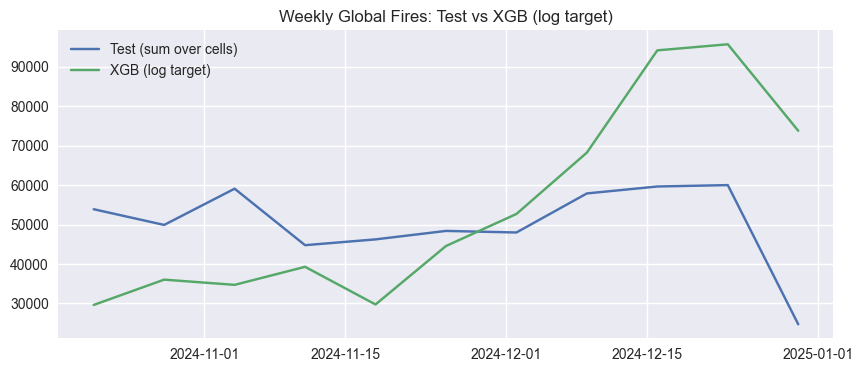

Saved global aggregated log-target forecast to data\processed\forecast_xgb_log_target_global.parquet


In [28]:

y_tr_log   = np.log1p(y_tr)
y_val_log  = np.log1p(y_val)
y_full_log = np.log1p(train[TARGET].values)

xgb_log = XGBRegressor(
    max_depth=3, learning_rate=0.1, n_estimators=600,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=10,
    reg_lambda=5, reg_alpha=0, objective="reg:squarederror",
    random_state=42, n_jobs=-1, eval_metric="rmse"
)
xgb_log.fit(X_tr, y_tr_log, eval_set=[(X_val, y_val_log)], verbose=False)
xgb_log.fit(train[FEATURES].values, y_full_log, verbose=False)

y_pred_log = np.expm1(xgb_log.predict(X_test))
y_pred_log = np.clip(y_pred_log, 0, None)

def smape(y_true, y_pred, eps=1e-8):
    d = (np.abs(y_true) + np.abs(y_pred) + eps) / 2.0
    return np.mean(np.abs(y_true - y_pred) / d) * 100

mae  = mean_absolute_error(y_test, y_pred_log)
rmse = root_mean_squared_error(y_test, y_pred_log)
smp  = smape(y_test, y_pred_log)
print(f"XGB (log target) ➜ MAE={mae:,.2f} | RMSE={rmse:,.2f} | SMAPE={smp:,.2f}%")

test_plot = test[["week"]].copy()
test_plot["y_true"] = y_test
test_plot["y_pred_log"] = y_pred_log
agg = test_plot.groupby("week")[["y_true","y_pred_log"]].sum().sort_index()

plt.figure(figsize=(10,4))
plt.plot(agg.index, agg["y_true"], label="Test (sum over cells)")
plt.plot(agg.index, agg["y_pred_log"], label="XGB (log target)")
plt.legend(); plt.title("Weekly Global Fires: Test vs XGB (log target)"); plt.show()

try:
    METRICS_PATH = Path("data/processed/metrics.csv"); METRICS_PATH.parent.mkdir(parents=True, exist_ok=True)
    row = pd.DataFrame([{"model":"xgb_log_target","MAE":mae,"RMSE":rmse,"SMAPE":smp}])
    (pd.concat([pd.read_csv(METRICS_PATH), row], ignore_index=True)
     if METRICS_PATH.exists() else row).to_csv(METRICS_PATH, index=False)
except Exception as e:
    print("Skipping metrics save:", e)

try:
    OUT = Path("data/processed/forecast_xgb_log_target_global.parquet"); OUT.parent.mkdir(parents=True, exist_ok=True)
    agg.reset_index().to_parquet(OUT, index=False)
    print("Saved global aggregated log-target forecast to", OUT)
except Exception as e:
    print("Skipping forecast save:", e)

XGB (log target + bias) ➜ MAE=5.54 | RMSE=10.32 | SMAPE=90.63% | bias=2.05


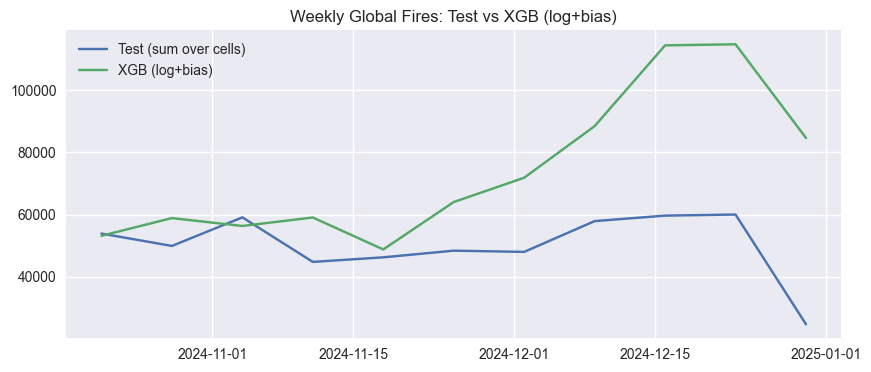

Saved global aggregated log+bias forecast to data\processed\forecast_xgb_log_target_bias_global.parquet


In [30]:
val_pred_log = np.clip(np.expm1(xgb_log.predict(X_val)), 0, None)
bias = (y_val - val_pred_log).mean()
y_pred_log_bc = np.clip(np.expm1(xgb_log.predict(X_test)) + bias, 0, None)

def smape(y_true, y_pred, eps=1e-8):
    d = (np.abs(y_true) + np.abs(y_pred) + eps) / 2.0
    return np.mean(np.abs(y_true - y_pred) / d) * 100

mae  = mean_absolute_error(y_test, y_pred_log_bc)
rmse = root_mean_squared_error(y_test, y_pred_log_bc)
smp  = smape(y_test, y_pred_log_bc)
print(f"XGB (log target + bias) ➜ MAE={mae:,.2f} | RMSE={rmse:,.2f} | SMAPE={smp:,.2f}% | bias={bias:,.2f}")

test_plot = test[["week"]].copy()
test_plot["y_true"] = y_test
test_plot["y_pred_log_bc"] = y_pred_log_bc
agg = test_plot.groupby("week")[["y_true","y_pred_log_bc"]].sum().sort_index()

plt.figure(figsize=(10,4))
plt.plot(agg.index, agg["y_true"], label="Test (sum over cells)")
plt.plot(agg.index, agg["y_pred_log_bc"], label="XGB (log+bias)")
plt.legend(); plt.title("Weekly Global Fires: Test vs XGB (log+bias)"); plt.show()

try:
    METRICS_PATH = Path("data/processed/metrics.csv"); METRICS_PATH.parent.mkdir(parents=True, exist_ok=True)
    row = pd.DataFrame([{"model":"xgb_log_target_bias","MAE":mae,"RMSE":rmse,"SMAPE":smp,"bias":bias}])
    (pd.concat([pd.read_csv(METRICS_PATH), row], ignore_index=True) if METRICS_PATH.exists() else row).to_csv(METRICS_PATH, index=False)
except Exception as e:
    print("Skipping metrics save:", e)

try:
    OUT = Path("data/processed/forecast_xgb_log_target_bias_global.parquet"); OUT.parent.mkdir(parents=True, exist_ok=True)
    agg.reset_index().to_parquet(OUT, index=False)
    print("Saved global aggregated log+bias forecast to", OUT)
except Exception as e:
    print("Skipping forecast save:", e)

,model,MAE,RMSE,SMAPE,bias
1,xgb_bias_corrected,5.009518,9.385456,84.616378,-0.024556
0,xgboost,5.137751,9.815733,85.239398,NaN
2,xgb_log_target,4.456755,10.020020,73.417674,NaN
3,xgb_log_target_bias,5.542380,10.316114,90.627371,2.054505


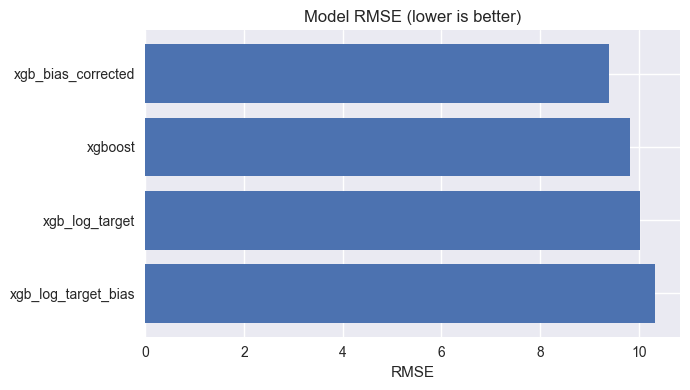

In [32]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

p = Path("data/processed/metrics.csv")
df = pd.read_csv(p) if p.exists() else pd.DataFrame(columns=["model","MAE","RMSE","SMAPE"])
df = df.copy()
df = df.sort_values("RMSE", ascending=True)
display(df)

plt.figure(figsize=(7,4))
plt.barh(df["model"], df["RMSE"])
plt.gca().invert_yaxis()
plt.title("Model RMSE (lower is better)")
plt.xlabel("RMSE")
plt.tight_layout()
plt.show()


In [34]:
truth = (weekly[weekly["week"].isin(test_weeks)]
         .groupby("week")["fire_count"].sum()
         .rename("y_true_global").to_frame())

def eval_global(path, pred_col, name):
    df = pd.read_parquet(path).set_index("week")
    merged = truth.join(df[[pred_col]], how="inner").rename(columns={pred_col:"y_pred"})
    mae  = mean_absolute_error(merged["y_true_global"], merged["y_pred"])
    rmse = root_mean_squared_error(merged["y_true_global"], merged["y_pred"])
    return {"model": name, "MAE_global": mae, "RMSE_global": rmse}

rows = []
rows.append(eval_global(Path("data/processed/forecast_xgb_global.parquet"),              "y_pred",      "xgb_global"))
rows.append(eval_global(Path("data/processed/forecast_xgb_bias_corrected_global.parquet"), "y_pred_bc",   "xgb_global_bias"))
rows.append(eval_global(Path("data/processed/forecast_xgb_log_target_global.parquet"),     "y_pred_log",  "xgb_global_log"))
rows.append(eval_global(Path("data/processed/forecast_xgb_log_target_bias_global.parquet"),"y_pred_log_bc","xgb_global_log_bias"))

pd.DataFrame(rows).sort_values("RMSE_global")

,model,MAE_global,RMSE_global
1,xgb_global_bias,20121.949929,24225.423920
0,xgb_global,21242.994673,24296.164458
2,xgb_global_log,20229.771662,24655.746439
3,xgb_global_log_bias,24407.522727,32488.097663


XGB reconciled with ARIMA ➜ MAE_global=5,848 | RMSE_global=8,205


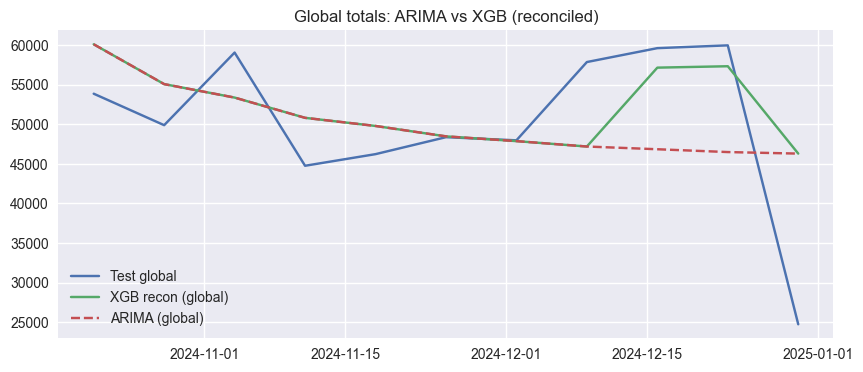

In [36]:
pred_vec = (
    y_pred_log_bc if "y_pred_log_bc" in locals() else
    y_pred_bc     if "y_pred_bc"     in locals() else
    y_pred_log    if "y_pred_log"    in locals() else
    y_pred
)

pred_cell = test[["week"]].copy()
pred_cell["pred"] = np.clip(pred_vec, 0, None)

assert "forecast_corrected" in locals() and "test_series" in locals(), \
    "Run the ARIMA (bias-corrected) cell first to define forecast_corrected & test_series."

arima_df = pd.DataFrame({"week": test_series.index, "arima": np.asarray(forecast_corrected)})

xgb_agg = pred_cell.groupby("week")["pred"].sum()
scale = (arima_df.set_index("week")["arima"] / xgb_agg).clip(0.5, 1.5)
pred_cell["pred_recon"] = pred_cell["pred"] * pred_cell["week"].map(scale).values

truth_global = test.groupby("week")["fire_count"].sum()
pred_global  = pred_cell.groupby("week")["pred_recon"].sum()

mae  = mean_absolute_error(truth_global, pred_global)
rmse = root_mean_squared_error(truth_global, pred_global)
print(f"XGB reconciled with ARIMA ➜ MAE_global={mae:,.0f} | RMSE_global={rmse:,.0f}")

plt.figure(figsize=(10,4))
plt.plot(truth_global.index, truth_global.values, label="Test global")
plt.plot(pred_global.index,  pred_global.values,  label="XGB recon (global)")
plt.plot(arima_df["week"],    arima_df["arima"],  label="ARIMA (global)", linestyle="--")
plt.legend(); plt.title("Global totals: ARIMA vs XGB (reconciled)"); plt.show()
